In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgbm

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train

country_code                 grass_date  user_id  subject_line_length  \
0                 4  2019-07-16 00:00:00+08:00       43                   44   
1                 4  2019-07-16 00:00:00+08:00      102                   44   
2                 6  2019-07-16 00:00:00+08:00      177                   49   
3                 1  2019-07-16 00:00:00+08:00      184                   49   
4                 6  2019-07-16 00:00:00+08:00      221                   49   
...             ...                        ...      ...                  ...   
71534             6  2019-09-02 00:00:00+08:00   127613                   39   
71535             2  2019-09-02 00:00:00+08:00   127620                   38   
71536             2  2019-09-02 00:00:00+08:00   127696                   32   
71537             2  2019-09-02 00:00:00+08:00   127807                   38   
71538             6  2019-09-02 00:00:00+08:00   127880                   39   

       last_open_day  last_login_day  last_checkout_day  \
0                 19               6                 18   
1                  9               4                  8   
2                 14               5                  5   
3                 49               9                 53   
4                227               6                221   
...              ...             ...                ...   
71534             24              36                279   
71535             46              10                 51   
71536            808           18141               1445   
71537              5              34               1445   
71538              1               3               1445   

       open_count_last_10_days  open_count_last_30_days  \
0                            0                        2   
1                            2                        9   
2                            0                        4   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
71534                        0                        1   
71535                        0                        0   
71536                        0                        0   
71537                        2                        4   
71538                        2                        2   

       open_count_last_60_days  ...  last_checkout_day_log  \
0                            4  ...               2.944439   
1                           17  ...               2.197225   
2                           12  ...               1.791759   
3                            1  ...               3.988984   
4                            0  ...               5.402677   
...                        ...  ...                    ...   
71534                        1  ...               5.634790   
71535                        1  ...               3.951244   
71536                        0  ...               7.276556   
71537                        4  ...               7.276556   
71538                        3  ...               7.276556   

       open_count_last_10_days_log  open_count_last_30_days_log  \
0                         0.000000                     1.098612   
1                         1.098612                     2.302585   
2                         0.000000                     1.609438   
3                         0.000000                     0.000000   
4                         0.000000                     0.000000   
...                            ...                          ...   
71534                     0.000000                     0.693147   
71535                     0.000000                     0.000000   
71536                     0.000000                     0.000000   
71537                     1.098612                     1.609438   
71538                     1.098612                     1.098612   

       open_count_last_60_days_log  login_count_last_10_days_log  \
0         

In [3]:
train.columns

Index(['country_code', 'grass_date', 'user_id', 'subject_line_length',
       'last_open_day', 'last_login_day', 'last_checkout_day',
       'open_count_last_10_days', 'open_count_last_30_days',
       'open_count_last_60_days', 'login_count_last_10_days',
       'login_count_last_30_days', 'login_count_last_60_days',
       'checkout_count_last_10_days', 'checkout_count_last_30_days',
       'checkout_count_last_60_days', 'open_flag', 'row_id', 'attr_1',
       'attr_2', 'attr_3', 'age', 'domain', 'day_of_week', 'user_id_count',
       'age_group', 'weekend', 'last_open_day_log', 'last_login_day_log',
       'last_checkout_day_log', 'open_count_last_10_days_log',
       'open_count_last_30_days_log', 'open_count_last_60_days_log',
       'login_count_last_10_days_log', 'login_count_last_30_days_log',
       'login_count_last_60_days_log', 'checkout_count_last_10_days_log',
       'checkout_count_last_30_days_log', 'checkout_count_last_60_days_log'],
      dtype='object')

open_flag
0    61083
1    10456
Name: country_code, dtype: int64


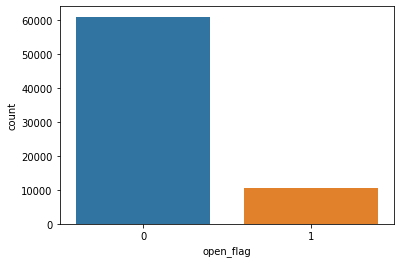

In [4]:
sns.countplot('open_flag', data=train)
print(train.groupby('open_flag').count()['country_code'])

open_flag
0    30000
1    30000
Name: country_code, dtype: int64


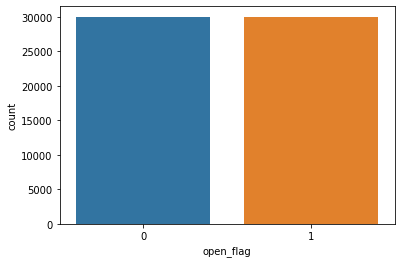

In [5]:
TRAIN_SIZE = 30000

df0 = train[train['open_flag'] == 0]
df0 = df0.sample(TRAIN_SIZE, random_state=0)

df1 = train[train['open_flag'] == 1]
df1 = df1.append(df1, ignore_index=True)
df1 = df1.append(df1, ignore_index=True)
df1 = df1.sample(TRAIN_SIZE, random_state=0)

train_resampled = pd.concat((df0, df1), ignore_index=True)

sns.countplot('open_flag', data=train_resampled)
print(train_resampled.groupby('open_flag').count()['country_code'])

In [6]:
def target_encoder(df, feature, label):
    ranking = df.groupby(feature).apply(lambda x: x[label].sum() / x[label].count())
    ranking = ranking.sort_values()

    encoder = {x: i for i, x in enumerate(ranking.index)}
    decoder = {i: x for i, x in enumerate(ranking.index)}
    return encoder, decoder

target_encoder(train_resampled, 'country_code', 'open_flag')

({1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6},
 {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4})

In [7]:
all_encoders = {}
all_decoders = {}

for x in ['country_code', 'domain', 'day_of_week']:
    encoder, decoder = target_encoder(train, x, 'open_flag')
    all_encoders[x] = encoder
    all_decoders[x] = decoder

    train_resampled[x + '_encoded'] = train_resampled[x].map(encoder)
    test[x + '_encoded'] = test[x].map(encoder)

print(all_encoders)
print(all_decoders)

{'country_code': {1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6}, 'domain': {'@gmail.com': 0, '@163.com': 1, '@yahoo.com': 2, '@ymail.com': 3, '@rocketmail.com': 4, '@outlook.com': 5, '@qq.com': 6, '@live.com': 7, '@icloud.com': 8, '@hotmail.com': 9, 'other': 10}, 'day_of_week': {5: 0, 1: 1, 0: 2, 3: 3, 6: 4, 4: 5, 2: 6}}
{'country_code': {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4}, 'domain': {0: '@gmail.com', 1: '@163.com', 2: '@yahoo.com', 3: '@ymail.com', 4: '@rocketmail.com', 5: '@outlook.com', 6: '@qq.com', 7: '@live.com', 8: '@icloud.com', 9: '@hotmail.com', 10: 'other'}, 'day_of_week': {0: 5, 1: 1, 2: 0, 3: 3, 4: 6, 5: 4, 6: 2}}


In [8]:
OLC = ('open', 'login', 'checkout')
DAYS = (10, 30, 60)

for x in DAYS:
    train_resampled[f'engine{x}'] = (train_resampled[f'checkout_count_last_{x}_days'] + 1) / (train_resampled[f'login_count_last_{x}_days'] + 1)
    test[f'engine{x}'] = (test[f'checkout_count_last_{x}_days'] + 1) / (test[f'login_count_last_{x}_days'] + 1)

for x in OLC:
    train_resampled[f'engine{x}1'] = train_resampled[f'{x}_count_last_30_days'] - train_resampled[f'{x}_count_last_10_days']
    train_resampled[f'engine{x}2'] = train_resampled[f'{x}_count_last_60_days'] - train_resampled[f'{x}_count_last_30_days']
    test[f'engine{x}1'] = test[f'{x}_count_last_30_days'] - test[f'{x}_count_last_10_days']
    test[f'engine{x}2'] = test[f'{x}_count_last_60_days'] - test[f'{x}_count_last_30_days']

In [9]:
encoded_features = \
    ['subject_line_length'] + \
    [f'last_{x}_day' for x in OLC] + \
    [f'last_{x}_day_log' for x in OLC] + \
    [f'{x}_count_last_{y}_days' for x in OLC for y in DAYS] + \
    [f'{x}_count_last_{y}_days_log' for x in OLC for y in DAYS] + \
    ['engine10', 'engine30', 'engine60',
    'attr_1', 'attr_2', 'attr_3',
    'country_code_encoded', 'domain_encoded', 'day_of_week_encoded',
    'user_id_count', 'age', 'age_group',
    'weekend']

In [10]:
len(encoded_features)

38

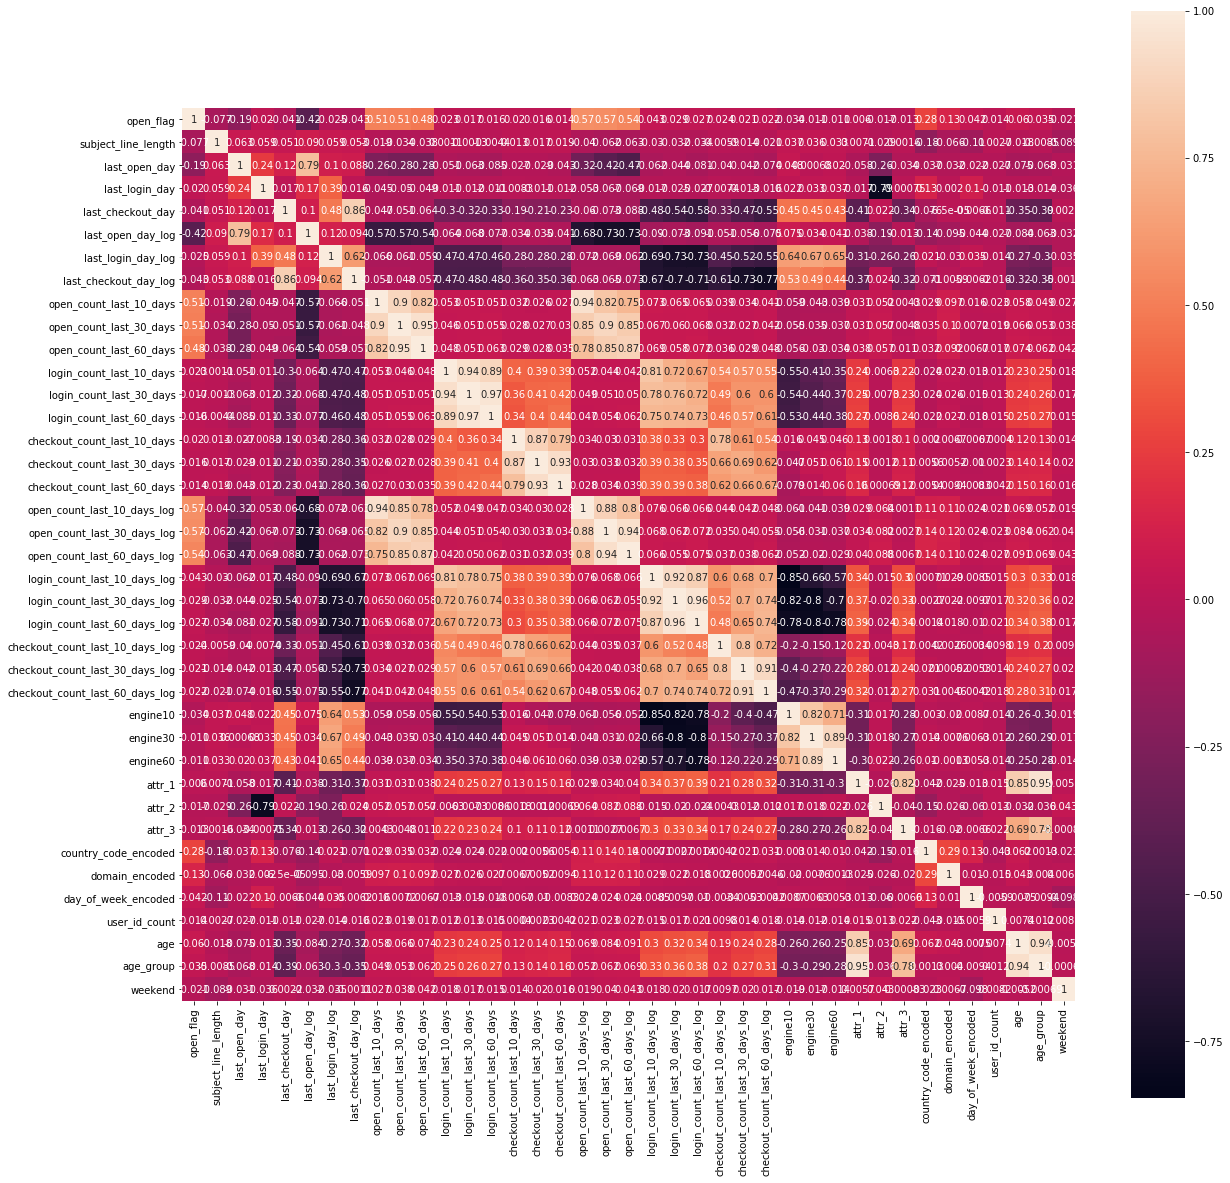

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(
    train_resampled.loc[:, ['open_flag'] + encoded_features].corr(), 
    square=True, annot=True
)

In [12]:
inputs = train_resampled.loc[:, encoded_features]
test_inputs = test.loc[:, encoded_features]

labels = train_resampled['open_flag']
test_labels = test['open_flag']

In [13]:
scale = StandardScaler()
inputs = scale.fit_transform(inputs)
test_inputs = scale.transform(test_inputs)

inputs

array([[-0.45444207, -0.20069689, -0.10842723, ...,  0.89673015,
         1.09331025, -0.50660613],
       [ 0.17346336, -0.336412  , -0.10692654, ...,  0.53220781,
         0.5173786 ,  1.97392005],
       [-0.18533974, -0.17261791, -0.10767689, ...,  0.37598396,
         0.5173786 , -0.50660613],
       ...,
       [-0.7235444 , -0.38789014, -0.10767689, ...,  1.57370019,
         1.6692419 , -0.50660613],
       [-0.18533974, -0.38789014, -0.097172  , ..., -1.08210538,
        -1.21041635, -0.50660613],
       [-0.00593819, -0.3223725 ,  0.04914599, ...,  1.78199867,
         1.6692419 , -0.50660613]])

In [14]:
def test_model(model, inputs, labels, test_inputs, test_labels):
    # print('Doing cross-validation...')
    # cv_acc = cross_val_score(model, inputs, labels)
    # print('CV accuracy: ', cv_acc, np.mean(cv_acc))

    print('Training model...')
    model.fit(inputs, labels)
    preds = model.predict(test_inputs)

    sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt="d")
    print('Test accuracy: ', accuracy_score(test_labels, preds))
    print('Test Matthews: ', matthews_corrcoef(test_labels, preds))

    return model

Training model...
Test accuracy:  0.7665
Test Matthews:  0.555717793940295


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

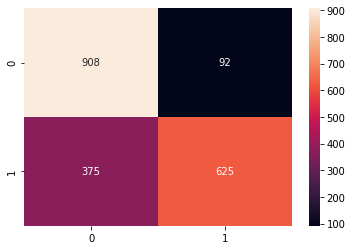

In [15]:
forest = RandomForestClassifier()
test_model(forest, inputs, labels, test_inputs, test_labels)

Training model...
Test accuracy:  0.796
Test Matthews:  0.5936275835443509


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

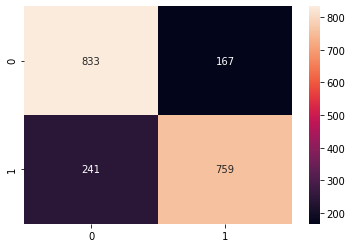

In [16]:
gbc = GradientBoostingClassifier()
test_model(gbc, inputs, labels, test_inputs, test_labels)

Training model...
Test accuracy:  0.796
Test Matthews:  0.5947469374813408


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

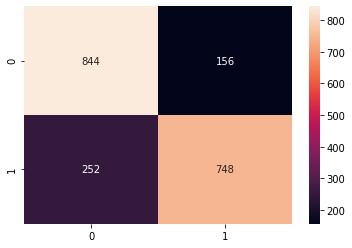

In [17]:
xgb_forest = XGBClassifier()
test_model(xgb_forest, inputs, labels, test_inputs, test_labels)

Training model...
Test accuracy:  0.804
Test Matthews:  0.6094105898148707


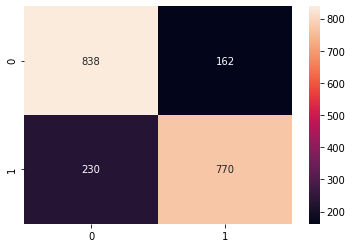

In [18]:
cat_clf = CatBoostClassifier(task_type='GPU', verbose=0)
test_model(cat_clf, inputs, labels, test_inputs, test_labels)


Training model...
Test accuracy:  0.7865
Test Matthews:  0.574706249524971


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

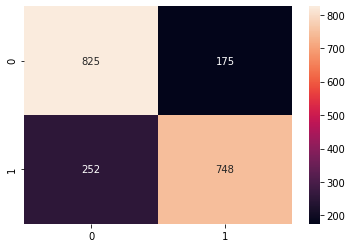

In [19]:
svm = SVC()
test_model(svm, inputs, labels, test_inputs, test_labels)

In [20]:
kaggle_test = pd.read_csv('test_kaggle.csv')
kaggle_test

country_code                 grass_date  user_id  subject_line_length  \
0                 6  2019-09-03 00:00:00+08:00        0                   35   
1                 6  2019-09-03 00:00:00+08:00      130                   35   
2                 5  2019-09-03 00:00:00+08:00      150                   25   
3                 1  2019-09-03 00:00:00+08:00      181                   36   
4                 5  2019-09-03 00:00:00+08:00      192                   23   
...             ...                        ...      ...                  ...   
55965             6  2019-09-29 00:00:00+08:00   127348                   53   
55966             6  2019-09-29 00:00:00+08:00   127396                   53   
55967             6  2019-09-29 00:00:00+08:00   127574                   43   
55968             6  2019-09-29 00:00:00+08:00   127887                   43   
55969             6  2019-09-29 00:00:00+08:00   127895                   53   

       last_open_day  last_login_day  last_checkout_day  \
0                 27               2                 13   
1                  7               5                383   
2                 34               1                  3   
3                 63               5                  5   
4                  6               5                 54   
...              ...             ...                ...   
55965            808               4                  8   
55966             59             802               1207   
55967            808               7               1445   
55968              5               5                  6   
55969              5               3                 20   

       open_count_last_10_days  open_count_last_30_days  \
0                            2                        3   
1                            1                        1   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
55965                        0                        0   
55966                        0                        0   
55967                        0                        0   
55968                        2                        5   
55969                        2                       14   

       open_count_last_60_days  ...  last_checkout_day_log  \
0                            4  ...               2.639057   
1                            1  ...               5.950643   
2                            0  ...               1.386294   
3                            0  ...               1.791759   
4                            0  ...               4.007333   
...                        ...  ...                    ...   
55965                        0  ...               2.197225   
55966                        1  ...               7.096721   
55967                        0  ...               7.276556   
55968                       14  ...               1.945910   
55969                       27  ...               3.044522   

       open_count_last_10_days_log  open_count_last_30_days_log  \
0                         1.098612                     1.386294   
1                         0.693147                     0.693147   
2                         0.000000                     0.000000   
3                         0.000000                     0.000000   
4                         0.000000                     0.000000   
...                            ...                          ...   
55965                     0.000000                     0.000000   
55966                     0.000000                     0.000000   
55967                     0.000000                     0.000000   
55968                     1.098612                     1.791759   
55969                     1.098612                     2.708050   

       open_count_last_60_days_log  login_count_last_10_days_log  \
0         

In [21]:
for feature, encoder in all_encoders.items():
    kaggle_test[feature + '_encoded'] = kaggle_test[feature].map(encoder)

for x in ['10', '30', '60']:
    kaggle_test['engine' + x] = (kaggle_test[f'checkout_count_last_{x}_days'] + 1) / (kaggle_test[f'login_count_last_{x}_days'] + 1)

for x in OLC:
    kaggle_test[f'engine{x}1'] = kaggle_test[f'{x}_count_last_30_days'] - kaggle_test[f'{x}_count_last_10_days']
    kaggle_test[f'engine{x}2'] = kaggle_test[f'{x}_count_last_60_days'] - kaggle_test[f'{x}_count_last_30_days']

kaggle_inputs = kaggle_test.loc[:, encoded_features]
kaggle_inputs = scale.transform(kaggle_inputs)

In [22]:
kaggle_preds = forest.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_forest.csv', index=False)
kaggle_test

country_code                 grass_date  user_id  subject_line_length  \
0                 6  2019-09-03 00:00:00+08:00        0                   35   
1                 6  2019-09-03 00:00:00+08:00      130                   35   
2                 5  2019-09-03 00:00:00+08:00      150                   25   
3                 1  2019-09-03 00:00:00+08:00      181                   36   
4                 5  2019-09-03 00:00:00+08:00      192                   23   
...             ...                        ...      ...                  ...   
55965             6  2019-09-29 00:00:00+08:00   127348                   53   
55966             6  2019-09-29 00:00:00+08:00   127396                   53   
55967             6  2019-09-29 00:00:00+08:00   127574                   43   
55968             6  2019-09-29 00:00:00+08:00   127887                   43   
55969             6  2019-09-29 00:00:00+08:00   127895                   53   

       last_open_day  last_login_day  last_checkout_day  \
0                 27               2                 13   
1                  7               5                383   
2                 34               1                  3   
3                 63               5                  5   
4                  6               5                 54   
...              ...             ...                ...   
55965            808               4                  8   
55966             59             802               1207   
55967            808               7               1445   
55968              5               5                  6   
55969              5               3                 20   

       open_count_last_10_days  open_count_last_30_days  \
0                            2                        3   
1                            1                        1   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
55965                        0                        0   
55966                        0                        0   
55967                        0                        0   
55968                        2                        5   
55969                        2                       14   

       open_count_last_60_days  ...  engine10  engine30  engine60  \
0                            4  ...  0.090909  0.200000  0.140741   
1                            1  ...  0.166667  0.166667  0.166667   
2                            0  ...  0.214286  0.150000  0.076923   
3                            0  ...  0.068182  0.054054  0.034483   
4                            0  ...  0.200000  0.076923  0.075000   
...                        ...  ...       ...       ...       ...   
55965                        0  ...  1.000000  1.000000  1.000000   
55966                        1  ...  1.000000  1.000000  1.000000   
55967                        0  ...  1.000000  1.000000  1.000000   
55968                       14  ...  1.000000  1.000000  1.000000   
55969                       27  ...  1.000000  1.000000  1.000000   

       engineopen1  engineopen2  enginelogin1  enginelogin2  enginecheckout1  \
0                1            1            24           100                6   
1                0            0             0             0                0   
2                0            0             6            19                0   
3                0            0            67            63                3   
4                0            0             8            27                0   
...            ...          ...           ...           ...              ...   
55965            0            0             0             0                0   
55966            0            1             0             0                0   
55967            0            0             0             0                0   

In [23]:
kaggle_preds = gbc.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_gbc.csv', index=False)
kaggle_test

country_code                 grass_date  user_id  subject_line_length  \
0                 6  2019-09-03 00:00:00+08:00        0                   35   
1                 6  2019-09-03 00:00:00+08:00      130                   35   
2                 5  2019-09-03 00:00:00+08:00      150                   25   
3                 1  2019-09-03 00:00:00+08:00      181                   36   
4                 5  2019-09-03 00:00:00+08:00      192                   23   
...             ...                        ...      ...                  ...   
55965             6  2019-09-29 00:00:00+08:00   127348                   53   
55966             6  2019-09-29 00:00:00+08:00   127396                   53   
55967             6  2019-09-29 00:00:00+08:00   127574                   43   
55968             6  2019-09-29 00:00:00+08:00   127887                   43   
55969             6  2019-09-29 00:00:00+08:00   127895                   53   

       last_open_day  last_login_day  last_checkout_day  \
0                 27               2                 13   
1                  7               5                383   
2                 34               1                  3   
3                 63               5                  5   
4                  6               5                 54   
...              ...             ...                ...   
55965            808               4                  8   
55966             59             802               1207   
55967            808               7               1445   
55968              5               5                  6   
55969              5               3                 20   

       open_count_last_10_days  open_count_last_30_days  \
0                            2                        3   
1                            1                        1   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
55965                        0                        0   
55966                        0                        0   
55967                        0                        0   
55968                        2                        5   
55969                        2                       14   

       open_count_last_60_days  ...  engine10  engine30  engine60  \
0                            4  ...  0.090909  0.200000  0.140741   
1                            1  ...  0.166667  0.166667  0.166667   
2                            0  ...  0.214286  0.150000  0.076923   
3                            0  ...  0.068182  0.054054  0.034483   
4                            0  ...  0.200000  0.076923  0.075000   
...                        ...  ...       ...       ...       ...   
55965                        0  ...  1.000000  1.000000  1.000000   
55966                        1  ...  1.000000  1.000000  1.000000   
55967                        0  ...  1.000000  1.000000  1.000000   
55968                       14  ...  1.000000  1.000000  1.000000   
55969                       27  ...  1.000000  1.000000  1.000000   

       engineopen1  engineopen2  enginelogin1  enginelogin2  enginecheckout1  \
0                1            1            24           100                6   
1                0            0             0             0                0   
2                0            0             6            19                0   
3                0            0            67            63                3   
4                0            0             8            27                0   
...            ...          ...           ...           ...              ...   
55965            0            0             0             0                0   
55966            0            1             0             0                0   
55967            0            0             0             0                0   

In [24]:
kaggle_preds = xgb_forest.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_xgb.csv', index=False)
kaggle_test

country_code                 grass_date  user_id  subject_line_length  \
0                 6  2019-09-03 00:00:00+08:00        0                   35   
1                 6  2019-09-03 00:00:00+08:00      130                   35   
2                 5  2019-09-03 00:00:00+08:00      150                   25   
3                 1  2019-09-03 00:00:00+08:00      181                   36   
4                 5  2019-09-03 00:00:00+08:00      192                   23   
...             ...                        ...      ...                  ...   
55965             6  2019-09-29 00:00:00+08:00   127348                   53   
55966             6  2019-09-29 00:00:00+08:00   127396                   53   
55967             6  2019-09-29 00:00:00+08:00   127574                   43   
55968             6  2019-09-29 00:00:00+08:00   127887                   43   
55969             6  2019-09-29 00:00:00+08:00   127895                   53   

       last_open_day  last_login_day  last_checkout_day  \
0                 27               2                 13   
1                  7               5                383   
2                 34               1                  3   
3                 63               5                  5   
4                  6               5                 54   
...              ...             ...                ...   
55965            808               4                  8   
55966             59             802               1207   
55967            808               7               1445   
55968              5               5                  6   
55969              5               3                 20   

       open_count_last_10_days  open_count_last_30_days  \
0                            2                        3   
1                            1                        1   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
55965                        0                        0   
55966                        0                        0   
55967                        0                        0   
55968                        2                        5   
55969                        2                       14   

       open_count_last_60_days  ...  engine10  engine30  engine60  \
0                            4  ...  0.090909  0.200000  0.140741   
1                            1  ...  0.166667  0.166667  0.166667   
2                            0  ...  0.214286  0.150000  0.076923   
3                            0  ...  0.068182  0.054054  0.034483   
4                            0  ...  0.200000  0.076923  0.075000   
...                        ...  ...       ...       ...       ...   
55965                        0  ...  1.000000  1.000000  1.000000   
55966                        1  ...  1.000000  1.000000  1.000000   
55967                        0  ...  1.000000  1.000000  1.000000   
55968                       14  ...  1.000000  1.000000  1.000000   
55969                       27  ...  1.000000  1.000000  1.000000   

       engineopen1  engineopen2  enginelogin1  enginelogin2  enginecheckout1  \
0                1            1            24           100                6   
1                0            0             0             0                0   
2                0            0             6            19                0   
3                0            0            67            63                3   
4                0            0             8            27                0   
...            ...          ...           ...           ...              ...   
55965            0            0             0             0                0   
55966            0            1             0             0                0   
55967            0            0             0             0                0   

In [25]:
kaggle_preds = cat_clf.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_cat.csv', index=False)
kaggle_test

country_code                 grass_date  user_id  subject_line_length  \
0                 6  2019-09-03 00:00:00+08:00        0                   35   
1                 6  2019-09-03 00:00:00+08:00      130                   35   
2                 5  2019-09-03 00:00:00+08:00      150                   25   
3                 1  2019-09-03 00:00:00+08:00      181                   36   
4                 5  2019-09-03 00:00:00+08:00      192                   23   
...             ...                        ...      ...                  ...   
55965             6  2019-09-29 00:00:00+08:00   127348                   53   
55966             6  2019-09-29 00:00:00+08:00   127396                   53   
55967             6  2019-09-29 00:00:00+08:00   127574                   43   
55968             6  2019-09-29 00:00:00+08:00   127887                   43   
55969             6  2019-09-29 00:00:00+08:00   127895                   53   

       last_open_day  last_login_day  last_checkout_day  \
0                 27               2                 13   
1                  7               5                383   
2                 34               1                  3   
3                 63               5                  5   
4                  6               5                 54   
...              ...             ...                ...   
55965            808               4                  8   
55966             59             802               1207   
55967            808               7               1445   
55968              5               5                  6   
55969              5               3                 20   

       open_count_last_10_days  open_count_last_30_days  \
0                            2                        3   
1                            1                        1   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
55965                        0                        0   
55966                        0                        0   
55967                        0                        0   
55968                        2                        5   
55969                        2                       14   

       open_count_last_60_days  ...  engine10  engine30  engine60  \
0                            4  ...  0.090909  0.200000  0.140741   
1                            1  ...  0.166667  0.166667  0.166667   
2                            0  ...  0.214286  0.150000  0.076923   
3                            0  ...  0.068182  0.054054  0.034483   
4                            0  ...  0.200000  0.076923  0.075000   
...                        ...  ...       ...       ...       ...   
55965                        0  ...  1.000000  1.000000  1.000000   
55966                        1  ...  1.000000  1.000000  1.000000   
55967                        0  ...  1.000000  1.000000  1.000000   
55968                       14  ...  1.000000  1.000000  1.000000   
55969                       27  ...  1.000000  1.000000  1.000000   

       engineopen1  engineopen2  enginelogin1  enginelogin2  enginecheckout1  \
0                1            1            24           100                6   
1                0            0             0             0                0   
2                0            0             6            19                0   
3                0            0            67            63                3   
4                0            0             8            27                0   
...            ...          ...           ...           ...              ...   
55965            0            0             0             0                0   
55966            0            1             0             0                0   
55967            0            0             0             0                0   

In [26]:
kaggle_preds = svm.predict(kaggle_inputs)
kaggle_test['open_flag'] = kaggle_preds
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_svm.csv', index=False)
kaggle_test

country_code                 grass_date  user_id  subject_line_length  \
0                 6  2019-09-03 00:00:00+08:00        0                   35   
1                 6  2019-09-03 00:00:00+08:00      130                   35   
2                 5  2019-09-03 00:00:00+08:00      150                   25   
3                 1  2019-09-03 00:00:00+08:00      181                   36   
4                 5  2019-09-03 00:00:00+08:00      192                   23   
...             ...                        ...      ...                  ...   
55965             6  2019-09-29 00:00:00+08:00   127348                   53   
55966             6  2019-09-29 00:00:00+08:00   127396                   53   
55967             6  2019-09-29 00:00:00+08:00   127574                   43   
55968             6  2019-09-29 00:00:00+08:00   127887                   43   
55969             6  2019-09-29 00:00:00+08:00   127895                   53   

       last_open_day  last_login_day  last_checkout_day  \
0                 27               2                 13   
1                  7               5                383   
2                 34               1                  3   
3                 63               5                  5   
4                  6               5                 54   
...              ...             ...                ...   
55965            808               4                  8   
55966             59             802               1207   
55967            808               7               1445   
55968              5               5                  6   
55969              5               3                 20   

       open_count_last_10_days  open_count_last_30_days  \
0                            2                        3   
1                            1                        1   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
55965                        0                        0   
55966                        0                        0   
55967                        0                        0   
55968                        2                        5   
55969                        2                       14   

       open_count_last_60_days  ...  engine10  engine30  engine60  \
0                            4  ...  0.090909  0.200000  0.140741   
1                            1  ...  0.166667  0.166667  0.166667   
2                            0  ...  0.214286  0.150000  0.076923   
3                            0  ...  0.068182  0.054054  0.034483   
4                            0  ...  0.200000  0.076923  0.075000   
...                        ...  ...       ...       ...       ...   
55965                        0  ...  1.000000  1.000000  1.000000   
55966                        1  ...  1.000000  1.000000  1.000000   
55967                        0  ...  1.000000  1.000000  1.000000   
55968                       14  ...  1.000000  1.000000  1.000000   
55969                       27  ...  1.000000  1.000000  1.000000   

       engineopen1  engineopen2  enginelogin1  enginelogin2  enginecheckout1  \
0                1            1            24           100                6   
1                0            0             0             0                0   
2                0            0             6            19                0   
3                0            0            67            63                3   
4                0            0             8            27                0   
...            ...          ...           ...           ...              ...   
55965            0            0             0             0                0   
55966            0            1             0             0                0   
55967            0            0             0             0                0   

In [27]:
df = pd.DataFrame()
df['forest'] = forest.predict(kaggle_inputs)
df['gbc'] = gbc.predict(kaggle_inputs)
df['xgb_forest'] = xgb_forest.predict(kaggle_inputs)
df['cat_clf'] = cat_clf.predict(kaggle_inputs)
df['svm'] = svm.predict(kaggle_inputs)
df

forest  gbc  xgb_forest  cat_clf  svm
0           1    1           1        1    1
1           0    0           1        1    1
2           0    0           0        0    0
3           0    0           0        0    0
4           0    0           0        0    0
...       ...  ...         ...      ...  ...
55965       0    0           0        0    0
55966       0    0           0        0    0
55967       0    0           0        0    0
55968       1    1           1        1    1
55969       1    1           1        1    1

[55970 rows x 5 columns]

In [28]:
df['all'] = (df['forest'] + df['gbc'] + df['xgb_forest'] + df['cat_clf'] + df['svm']) / 5
df

forest  gbc  xgb_forest  cat_clf  svm  all
0           1    1           1        1    1  1.0
1           0    0           1        1    1  0.6
2           0    0           0        0    0  0.0
3           0    0           0        0    0  0.0
4           0    0           0        0    0  0.0
...       ...  ...         ...      ...  ...  ...
55965       0    0           0        0    0  0.0
55966       0    0           0        0    0  0.0
55967       0    0           0        0    0  0.0
55968       1    1           1        1    1  1.0
55969       1    1           1        1    1  1.0

[55970 rows x 6 columns]

In [29]:
df.groupby('all').count()

forest    gbc  xgb_forest  cat_clf    svm
all                                           
0.0   39949  39949       39949    39949  39949
0.2    2501   2501        2501     2501   2501
0.4    1297   1297        1297     1297   1297
0.6    1550   1550        1550     1550   1550
0.8    2570   2570        2570     2570   2570
1.0    8103   8103        8103     8103   8103

In [30]:
df = pd.DataFrame()
df['forest'] = forest.predict_proba(kaggle_inputs)[:, 1]
df['gbc'] = gbc.predict_proba(kaggle_inputs)[:, 1]
df['xgb_forest'] = xgb_forest.predict_proba(kaggle_inputs)[:, 1]
df['cat_clf'] = cat_clf.predict_proba(kaggle_inputs)[:, 1]
df

forest       gbc  xgb_forest   cat_clf
0        0.65  0.701433    0.819506  0.717126
1        0.29  0.434880    0.507346  0.523954
2        0.18  0.227370    0.109887  0.200326
3        0.09  0.124580    0.090641  0.075946
4        0.17  0.260621    0.298204  0.259886
...       ...       ...         ...       ...
55965    0.13  0.200629    0.148557  0.166862
55966    0.21  0.201635    0.119228  0.168837
55967    0.13  0.184694    0.113332  0.114224
55968    0.69  0.829082    0.690830  0.711134
55969    0.82  0.913908    0.911236  0.928387

[55970 rows x 4 columns]

In [31]:
df['all'] = (df['forest'] + df['gbc'] + df['xgb_forest'] + df['cat_clf']) / 4
df

forest       gbc  xgb_forest   cat_clf       all
0        0.65  0.701433    0.819506  0.717126  0.722016
1        0.29  0.434880    0.507346  0.523954  0.439045
2        0.18  0.227370    0.109887  0.200326  0.179396
3        0.09  0.124580    0.090641  0.075946  0.095292
4        0.17  0.260621    0.298204  0.259886  0.247178
...       ...       ...         ...       ...       ...
55965    0.13  0.200629    0.148557  0.166862  0.161512
55966    0.21  0.201635    0.119228  0.168837  0.174925
55967    0.13  0.184694    0.113332  0.114224  0.135562
55968    0.69  0.829082    0.690830  0.711134  0.730261
55969    0.82  0.913908    0.911236  0.928387  0.893383

[55970 rows x 5 columns]

In [32]:
kaggle_test['open_flag'] = (df['all'] >= 0.5).astype(int)
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_ensemble.csv', index=False)
kaggle_test

country_code                 grass_date  user_id  subject_line_length  \
0                 6  2019-09-03 00:00:00+08:00        0                   35   
1                 6  2019-09-03 00:00:00+08:00      130                   35   
2                 5  2019-09-03 00:00:00+08:00      150                   25   
3                 1  2019-09-03 00:00:00+08:00      181                   36   
4                 5  2019-09-03 00:00:00+08:00      192                   23   
...             ...                        ...      ...                  ...   
55965             6  2019-09-29 00:00:00+08:00   127348                   53   
55966             6  2019-09-29 00:00:00+08:00   127396                   53   
55967             6  2019-09-29 00:00:00+08:00   127574                   43   
55968             6  2019-09-29 00:00:00+08:00   127887                   43   
55969             6  2019-09-29 00:00:00+08:00   127895                   53   

       last_open_day  last_login_day  last_checkout_day  \
0                 27               2                 13   
1                  7               5                383   
2                 34               1                  3   
3                 63               5                  5   
4                  6               5                 54   
...              ...             ...                ...   
55965            808               4                  8   
55966             59             802               1207   
55967            808               7               1445   
55968              5               5                  6   
55969              5               3                 20   

       open_count_last_10_days  open_count_last_30_days  \
0                            2                        3   
1                            1                        1   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
55965                        0                        0   
55966                        0                        0   
55967                        0                        0   
55968                        2                        5   
55969                        2                       14   

       open_count_last_60_days  ...  engine10  engine30  engine60  \
0                            4  ...  0.090909  0.200000  0.140741   
1                            1  ...  0.166667  0.166667  0.166667   
2                            0  ...  0.214286  0.150000  0.076923   
3                            0  ...  0.068182  0.054054  0.034483   
4                            0  ...  0.200000  0.076923  0.075000   
...                        ...  ...       ...       ...       ...   
55965                        0  ...  1.000000  1.000000  1.000000   
55966                        1  ...  1.000000  1.000000  1.000000   
55967                        0  ...  1.000000  1.000000  1.000000   
55968                       14  ...  1.000000  1.000000  1.000000   
55969                       27  ...  1.000000  1.000000  1.000000   

       engineopen1  engineopen2  enginelogin1  enginelogin2  enginecheckout1  \
0                1            1            24           100                6   
1                0            0             0             0                0   
2                0            0             6            19                0   
3                0            0            67            63                3   
4                0            0             8            27                0   
...            ...          ...           ...           ...              ...   
55965            0            0             0             0                0   
55966            0            1             0             0                0   
55967            0            0             0             0                0   